In [1]:
import numpy as np
from pathlib import Path
import Visualisation_utils
import matplotlib.pyplot as plt

from active_learning import get_high_variance_cells

LOG_DIR = Path("log/active_learning/AL: testing")


In [2]:
with np.load(LOG_DIR / 'train' / 'val_predictions.npz') as npz_file:
    predict_points = npz_file['points']
    predict_preds = npz_file['preds']
    predict_target = npz_file['target']
    predict_variance = npz_file['variance']  # Variances are normalised to [-1,1]
    predict_point_variance = npz_file['point_variance']
    predict_grid_mask = npz_file['grid_mask']
    predict_features = npz_file['features']
    predict_samples_per_cell = npz_file['samples_per_cell']

In [3]:
cell_centers = np.array([np.mean(predict_points[np.where(predict_grid_mask==i)[0],:3], axis=0) for i in range(len(predict_variance))])

In [4]:
a = np.array([[0,10],[1,11],[2,12]])
print(a.shape)
np.mean(a, axis=0)

(3, 2)


array([ 1., 11.])

(-20.0, 20.0)

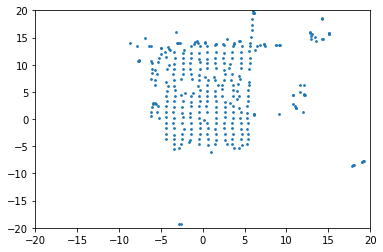

In [18]:
plt.scatter(cell_centers[:,0], cell_centers[:,1], s=3)
plt.xlim(-20,20)
plt.ylim(-20,20)

In [6]:
variance_ordering_idxs = predict_variance.argsort()[::-1]
num_cells = 10

In [ ]:
import matplotlib.pyplot as plt
from sklearn import cluster

In [ ]:
kmeans = cluster.KMeans(n_clusters=num_cells, random_state=0).fit(predict_features)

## ReDAL
Score each sample with its uncertainty U

Clusters the samples into K clusters based on their feature embeddings

Sort the regions based on the uncertainty U

For each region, penalise the scores of the remaining regions in that cluster by some factor P

The result is a ranking of regions based on uncertainty and diversity (such that the most uncertain regions are ranked first, but repeat regions from the same cluster are unlikely).

In [ ]:
for idx in variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {predict_variance[idx]:.4f} ")

In [ ]:
penalty_factor = 0.9
adjusted_variance = np.copy(predict_variance)
for i, idx in enumerate(variance_ordering_idxs):
    current_cluster = kmeans.labels_[idx]
    for x in range(i+1, len(variance_ordering_idxs)):
        x = variance_ordering_idxs[x]
        if kmeans.labels_[x] == current_cluster:
            adjusted_variance[x] *= penalty_factor

print(f"Old variance_ordering_idxs:\n{variance_ordering_idxs[:10]}")
adjusted_variance_ordering_idxs = adjusted_variance.argsort()[::-1]
print(f"New variance_ordering_idxs:\n{adjusted_variance_ordering_idxs[:10]}")
for idx in adjusted_variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {adjusted_variance[idx]:.4f}")